# Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore") 

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [3]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [4]:
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [5]:
data = data.resample("M").apply('mean')

In [6]:
data['PJME_MW'].values.shape

(200,)

2. Подберите параметры модели SARIMAX для этого ряда.


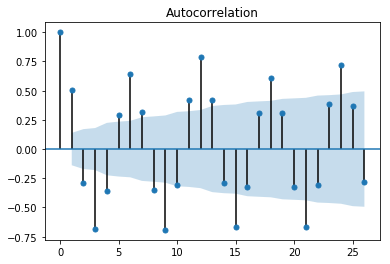

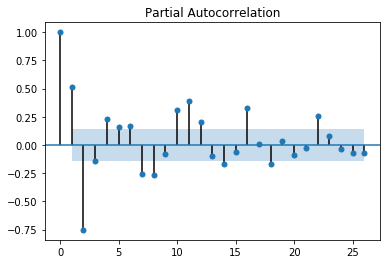

In [7]:
sm.graphics.tsa.plot_acf(data['PJME_MW'].values, lags=26)
plt.show()
sm.graphics.tsa.plot_pacf(data['PJME_MW'].values, lags=26)
plt.show()

Сезонность видна из ACF - лаг 12 дает большую корреляцию. чем лаг 6 - сезон = 12

проверим интуитивную модель с сезоном 12 и зададим глубину истории и сглаживания 2.

In [12]:
result = sm.tsa.statespace.SARIMAX((data['PJME_MW'].values[-500:-100]),
                                          order=[2,0, 2],seasonal_order=[0,0,0,12],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
result_s = result.fit() 

Сравним эту модель с подбором модели по сетке

Сезонность определили - 12
порядок глубины истории для сезонности не более 3 (ACF: лаг 12 и 24 выше синенькой полосы , вот 36 видимо будет уже в ней - т.о. берем не более 3-х лет истории по сезонам и не менее 1-го )
Сглаживание определим тоже до 3-х 
порядок интегрирования не берем больше 2 - иначе будет очень сложная модель.

Для остатков сезонной модели - ряд достаточно гладкий - мало измерений - ограничим сложность по h и q до 3, а по d не более 2- 

In [13]:
import itertools
# Определим p, d и q в диапазоне 0-3
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
# зададим сетку p, q и q для сезонов
pdq = list(itertools.product(p, d, q))
p = range(1, 3)
d = range(0, 2)
q = range(0, 3)
seasonal_pdq = list(itertools.product(p, d, q, [12]))#[0,0,0,52] # нет сезона

aics = {}

for kk in range(len(pdq)):
    for k in range(len(seasonal_pdq)):
        param = pdq[kk]
        params=seasonal_pdq[k]
        print(seasonal_pdq[k])
        try:
            mod_b = sm.tsa.statespace.SARIMAX((data['PJME_MW'].values[-500:-100]),
                                              order=param,seasonal_order=params,trend='ct',
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)

            results_ = mod_b.fit()
            aics[results_.aic] = param
            print('ARIMA{}x{} - AIC:{}'.format(param, params, results_.aic))
        except:
            continue

(1, 0, 0, 12)
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1679.1385187793248
(1, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1610.6418379936779
(1, 0, 2, 12)
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:1400.1318841737018
(1, 1, 0, 12)
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1350.6889835227828
(1, 1, 1, 12)
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1338.6997253291845
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:2634.3449136116087
(2, 0, 0, 12)
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:1448.2827289276672
(2, 0, 1, 12)
ARIMA(0, 0, 0)x(2, 0, 1, 12) - AIC:1422.1458301533678
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 0, 2, 12) - AIC:1401.9784450631819
(2, 1, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 1, 0, 12) - AIC:1127.3749566704603
(2, 1, 1, 12)
ARIMA(0, 0, 0)x(2, 1, 1, 12) - AIC:1132.0921181476458
(2, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 1, 2, 12) - AIC:2814.3022769699764
(1, 0, 0, 12)
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1649.3628442489994
(1, 0, 1, 12)
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1602.8955450477156
(1, 0, 2, 12)
ARIMA(0, 0, 1)x(1, 0, 2, 12) - AIC:1379.4498999247633
(1, 1, 0, 12)
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:1352.8001842858848
(1, 1, 1, 12)
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:1321.9336893055759
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 2, 12) - AIC:3038.7578836726025
(2, 0, 0, 12)
ARIMA(0, 0, 1)x(2, 0, 0, 12) - AIC:1425.2321220870092
(2, 0, 1, 12)
ARIMA(0, 0, 1)x(2, 0, 1, 12) - AIC:1420.915151562986
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(2, 0, 2, 12) - AIC:1380.4481910082725
(2, 1, 0, 12)
ARIMA(0, 0, 1)x(2, 1, 0, 12) - AIC:1136.5891358283832
(2, 1, 1, 12)
ARIMA(0, 0, 1)x(2, 1, 1, 12) - AIC:1133.3398611043083
(2, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(2, 1, 2, 12) - AIC:2579.4443544026253
(1, 0, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(1, 0, 0, 12) - AIC:1624.1024606197493
(1, 0, 1, 12)
ARIMA(0, 0, 2)x(1, 0, 1, 12) - AIC:1572.881022603255
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(1, 0, 2, 12) - AIC:1353.7144922424968
(1, 1, 0, 12)
ARIMA(0, 0, 2)x(1, 1, 0, 12) - AIC:1355.522908175979
(1, 1, 1, 12)
ARIMA(0, 0, 2)x(1, 1, 1, 12) - AIC:1306.1442102471349
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(1, 1, 2, 12) - AIC:2847.782760602589
(2, 0, 0, 12)
ARIMA(0, 0, 2)x(2, 0, 0, 12) - AIC:1414.8637889667039
(2, 0, 1, 12)
ARIMA(0, 0, 2)x(2, 0, 1, 12) - AIC:1410.184674702389
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 0, 2, 12) - AIC:1355.3304025165305
(2, 1, 0, 12)
ARIMA(0, 0, 2)x(2, 1, 0, 12) - AIC:1137.611489551868
(2, 1, 1, 12)
ARIMA(0, 0, 2)x(2, 1, 1, 12) - AIC:1134.626638020785
(2, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 1, 2, 12) - AIC:2539.2294867634205
(1, 0, 0, 12)
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:1594.1359789873998
(1, 0, 1, 12)
ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1565.7238034485172
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 2, 12) - AIC:1339.4636683153851
(1, 1, 0, 12)
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:1370.8948775013603
(1, 1, 1, 12)
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:1348.4492056931945
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 2, 12) - AIC:2635.334042687761
(2, 0, 0, 12)
ARIMA(0, 1, 0)x(2, 0, 0, 12) - AIC:1368.8184435066203
(2, 0, 1, 12)
ARIMA(0, 1, 0)x(2, 0, 1, 12) - AIC:1364.4987874016986
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(2, 0, 2, 12) - AIC:1339.9420232699522
(2, 1, 0, 12)
ARIMA(0, 1, 0)x(2, 1, 0, 12) - AIC:1142.1561560830262
(2, 1, 1, 12)
ARIMA(0, 1, 0)x(2, 1, 1, 12) - AIC:1143.5041710725038
(2, 1, 2, 12)
ARIMA(0, 1, 0)x(2, 1, 2, 12) - AIC:4763.699454707682
(1, 0, 0, 12)
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:1586.8483928675746
(1, 0, 1, 12)
ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:1525.8300584150475
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 2, 12) - AIC:1304.1550116986707
(1, 1, 0, 12)
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:1351.9533710529015
(1, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:1302.3316594738794
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 2, 12) - AIC:2823.3597576472635
(2, 0, 0, 12)
ARIMA(0, 1, 1)x(2, 0, 0, 12) - AIC:1345.059901538716
(2, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 0, 1, 12) - AIC:1352.196438385867
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 0, 2, 12) - AIC:1324.3604532140514
(2, 1, 0, 12)
ARIMA(0, 1, 1)x(2, 1, 0, 12) - AIC:1130.7773103813242
(2, 1, 1, 12)
ARIMA(0, 1, 1)x(2, 1, 1, 12) - AIC:1131.0778879613504
(2, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 1, 2, 12) - AIC:4673.468758891186
(1, 0, 0, 12)
ARIMA(0, 1, 2)x(1, 0, 0, 12) - AIC:1586.5395891949968
(1, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 0, 1, 12) - AIC:1503.447977710637
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 0, 2, 12) - AIC:1278.9484084309984
(1, 1, 0, 12)
ARIMA(0, 1, 2)x(1, 1, 0, 12) - AIC:1352.665111261977
(1, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 1, 1, 12) - AIC:1284.2783080191462
(1, 1, 2, 12)
ARIMA(0, 1, 2)x(1, 1, 2, 12) - AIC:2479.8032899685873
(2, 0, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 0, 0, 12) - AIC:1350.5584052985378
(2, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 0, 1, 12) - AIC:1372.7841213067716
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:1313.62137262538
(2, 1, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 1, 0, 12) - AIC:1125.6888925963958
(2, 1, 1, 12)
ARIMA(0, 1, 2)x(2, 1, 1, 12) - AIC:1133.071160287772
(2, 1, 2, 12)
ARIMA(0, 1, 2)x(2, 1, 2, 12) - AIC:4597.678126734244
(1, 0, 0, 12)
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:1602.4328241535436
(1, 0, 1, 12)
ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:1603.4500532813424
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 2, 12) - AIC:1382.9816745076344
(1, 1, 0, 12)
ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:1334.82735520983
(1, 1, 1, 12)
ARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC:1337.6779829913805
(1, 1, 2, 12)
ARIMA(1, 0, 0)x(1, 1, 2, 12) - AIC:2679.114626552654
(2, 0, 0, 12)
ARIMA(1, 0, 0)x(2, 0, 0, 12) - AIC:1380.4633976496234
(2, 0, 1, 12)
ARIMA(1, 0, 0)x(2, 0, 1, 12) - AIC:1380.841342013494
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 0, 2, 12) - AIC:1381.8677451752033
(2, 1, 0, 12)
ARIMA(1, 0, 0)x(2, 1, 0, 12) - AIC:1116.9639900798802
(2, 1, 1, 12)
ARIMA(1, 0, 0)x(2, 1, 1, 12) - AIC:1118.8263504760218
(2, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 1, 2, 12) - AIC:3099.176158376189
(1, 0, 0, 12)
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:1572.6554168228918
(1, 0, 1, 12)
ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:1553.4393339565559
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 2, 12) - AIC:1348.021956113545
(1, 1, 0, 12)
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:1336.383461329483
(1, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:1316.7569048624077
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 2, 12) - AIC:2780.576822208498
(2, 0, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 0, 12) - AIC:1359.4126268644188
(2, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 1, 12) - AIC:1354.185325582441
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 2, 12) - AIC:1344.8674561023674
(2, 1, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 1, 0, 12) - AIC:1113.2072574046458
(2, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 1, 1, 12) - AIC:1117.4472940219125
(2, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 1, 2, 12) - AIC:2345.330557166818
(1, 0, 0, 12)
ARIMA(1, 0, 2)x(1, 0, 0, 12) - AIC:1590.5427822207814
(1, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 0, 1, 12) - AIC:1553.9669871779802
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 0, 2, 12) - AIC:1341.950639487968
(1, 1, 0, 12)
ARIMA(1, 0, 2)x(1, 1, 0, 12) - AIC:1337.6996058352831
(1, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 1, 1, 12) - AIC:1299.5863102848816
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 1, 2, 12) - AIC:2595.0857865406897
(2, 0, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 0, 12) - AIC:1372.0301265098853
(2, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 12) - AIC:1376.5777677204558
(2, 0, 2, 12)
ARIMA(1, 0, 2)x(2, 0, 2, 12) - AIC:1342.101440719205
(2, 1, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 0, 12) - AIC:1117.3979156399078
(2, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 1, 12) - AIC:1121.9531942128417
(2, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 2, 12) - AIC:2466.436214050992
(1, 0, 0, 12)
ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:1570.3048246411345
(1, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1558.7199246377563
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 2, 12) - AIC:1330.8212520966767
(1, 1, 0, 12)
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:1343.5515500064962
(1, 1, 1, 12)
ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:1338.9185713785537
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 2, 12) - AIC:2923.3962596848055
(2, 0, 0, 12)
ARIMA(1, 1, 0)x(2, 0, 0, 12) - AIC:1342.7419624711313
(2, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 0, 1, 12) - AIC:1336.7857363381013
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 0, 2, 12) - AIC:1363.5893314718217
(2, 1, 0, 12)
ARIMA(1, 1, 0)x(2, 1, 0, 12) - AIC:1118.0433054174835
(2, 1, 1, 12)
ARIMA(1, 1, 0)x(2, 1, 1, 12) - AIC:1119.0976686631634
(2, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 1, 2, 12) - AIC:4757.668777454526
(1, 0, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:1552.9570751845831
(1, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:1541.1247269923329
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 2, 12) - AIC:1309.4136857975327
(1, 1, 0, 12)
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:1333.9345175959513
(1, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:1302.5034663766066
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 2, 12) - AIC:2354.770383865051
(2, 0, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 0, 0, 12) - AIC:1323.6488508323325
(2, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 0, 1, 12) - AIC:1352.500933488602
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 0, 2, 12) - AIC:1344.2714306594246
(2, 1, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 0, 12) - AIC:1105.9546325277202
(2, 1, 1, 12)
ARIMA(1, 1, 1)x(2, 1, 1, 12) - AIC:1105.831106821073
(2, 1, 2, 12)
ARIMA(1, 1, 1)x(2, 1, 2, 12) - AIC:4674.020553210079
(1, 0, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 0, 0, 12) - AIC:1568.344580481149
(1, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 0, 1, 12) - AIC:1539.6496711688067
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 0, 2, 12) - AIC:1293.0094721276214
(1, 1, 0, 12)
ARIMA(1, 1, 2)x(1, 1, 0, 12) - AIC:1337.1696456139423
(1, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 1, 1, 12) - AIC:1286.3499352541546
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 1, 2, 12) - AIC:2305.7245051182354
(2, 0, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 0, 0, 12) - AIC:1347.6819780940796
(2, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 0, 1, 12) - AIC:1341.0741767466995
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 0, 2, 12) - AIC:1298.0994851370688
(2, 1, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 0, 12) - AIC:1109.6353880846466
(2, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 1, 12) - AIC:1109.9647068128534
(2, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 2, 12) - AIC:4598.508109831014
(1, 0, 0, 12)
ARIMA(2, 0, 0)x(1, 0, 0, 12) - AIC:1560.2890316348376
(1, 0, 1, 12)
ARIMA(2, 0, 0)x(1, 0, 1, 12) - AIC:1560.2663157618701
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(1, 0, 2, 12) - AIC:1364.6466319785452
(1, 1, 0, 12)
ARIMA(2, 0, 0)x(1, 1, 0, 12) - AIC:1321.4704757474467
(1, 1, 1, 12)
ARIMA(2, 0, 0)x(1, 1, 1, 12) - AIC:1321.6511155381083
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(1, 1, 2, 12) - AIC:2942.643924814344
(2, 0, 0, 12)
ARIMA(2, 0, 0)x(2, 0, 0, 12) - AIC:1347.7391560352805
(2, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 0, 1, 12) - AIC:1349.1611751205241
(2, 0, 2, 12)
ARIMA(2, 0, 0)x(2, 0, 2, 12) - AIC:1350.220875466427
(2, 1, 0, 12)
ARIMA(2, 0, 0)x(2, 1, 0, 12) - AIC:1104.8431027320273
(2, 1, 1, 12)
ARIMA(2, 0, 0)x(2, 1, 1, 12) - AIC:1100.827606133953
(2, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 1, 2, 12) - AIC:2097.161466342241
(1, 0, 0, 12)
ARIMA(2, 0, 1)x(1, 0, 0, 12) - AIC:1571.556278373401
(1, 0, 1, 12)
ARIMA(2, 0, 1)x(1, 0, 1, 12) - AIC:1562.0189407376656
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 2, 12) - AIC:1349.0255937230454
(1, 1, 0, 12)
ARIMA(2, 0, 1)x(1, 1, 0, 12) - AIC:1324.7328469936804
(1, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 12) - AIC:1316.4006429421227
(1, 1, 2, 12)
ARIMA(2, 0, 1)x(1, 1, 2, 12) - AIC:5424.617872043707
(2, 0, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 0, 12) - AIC:1359.7526278921114
(2, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 12) - AIC:1352.662421404835
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 2, 12) - AIC:1349.8177996166758
(2, 1, 0, 12)
ARIMA(2, 0, 1)x(2, 1, 0, 12) - AIC:1107.5676950279135
(2, 1, 1, 12)
ARIMA(2, 0, 1)x(2, 1, 1, 12) - AIC:1105.9800439817295
(2, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 1, 2, 12) - AIC:5210.150071598915
(1, 0, 0, 12)
ARIMA(2, 0, 2)x(1, 0, 0, 12) - AIC:1534.1403815762483
(1, 0, 1, 12)
ARIMA(2, 0, 2)x(1, 0, 1, 12) - AIC:1518.9474971188354
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 2, 12) - AIC:1309.52110193502
(1, 1, 0, 12)
ARIMA(2, 0, 2)x(1, 1, 0, 12) - AIC:1324.0173128675904
(1, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 1, 1, 12) - AIC:1300.577786189873
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 1, 2, 12) - AIC:2299.2133265368925
(2, 0, 0, 12)
ARIMA(2, 0, 2)x(2, 0, 0, 12) - AIC:1327.9802903755071
(2, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 12) - AIC:1328.6559365663256
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 2, 12) - AIC:1310.8860719866232
(2, 1, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 0, 12) - AIC:1104.9976979505627
(2, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 1, 12) - AIC:1104.0236660717078
(2, 1, 2, 12)
ARIMA(2, 0, 2)x(2, 1, 2, 12) - AIC:2615.324799426745
(1, 0, 0, 12)
ARIMA(2, 1, 0)x(1, 0, 0, 12) - AIC:1544.160304536488
(1, 0, 1, 12)
ARIMA(2, 1, 0)x(1, 0, 1, 12) - AIC:1530.6771651857389
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(1, 0, 2, 12) - AIC:1321.7600191514882
(1, 1, 0, 12)
ARIMA(2, 1, 0)x(1, 1, 0, 12) - AIC:1314.7734903620803
(1, 1, 1, 12)
ARIMA(2, 1, 0)x(1, 1, 1, 12) - AIC:1309.765428173253
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(1, 1, 2, 12) - AIC:2475.7328628185164
(2, 0, 0, 12)
ARIMA(2, 1, 0)x(2, 0, 0, 12) - AIC:1314.7919128383126
(2, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 0, 1, 12) - AIC:1309.3455105052383
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 0, 2, 12) - AIC:1331.487147288458
(2, 1, 0, 12)
ARIMA(2, 1, 0)x(2, 1, 0, 12) - AIC:1094.727159827871
(2, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 1, 1, 12) - AIC:1096.212400284983
(2, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 1, 2, 12) - AIC:4675.371790185943
(1, 0, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 0, 0, 12) - AIC:1545.5132278988274
(1, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 0, 1, 12) - AIC:1527.9123938830767
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 0, 2, 12) - AIC:1315.43531475286
(1, 1, 0, 12)
ARIMA(2, 1, 1)x(1, 1, 0, 12) - AIC:1315.5677003010787
(1, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 12) - AIC:1304.891889712752
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 1, 2, 12) - AIC:2386.923914283523
(2, 0, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 0, 0, 12) - AIC:1313.5395702582855
(2, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 0, 1, 12) - AIC:1302.8058635146467
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 0, 2, 12) - AIC:1316.9923051513026
(2, 1, 0, 12)
ARIMA(2, 1, 1)x(2, 1, 0, 12) - AIC:1096.1221679933471
(2, 1, 1, 12)
ARIMA(2, 1, 1)x(2, 1, 1, 12) - AIC:1094.123558292514
(2, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 2, 12) - AIC:4674.678817723035
(1, 0, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:1528.008986550815
(1, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:1502.9225988379324
(1, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:1288.7688592500187
(1, 1, 0, 12)
ARIMA(2, 1, 2)x(1, 1, 0, 12) - AIC:1319.5179412629664
(1, 1, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 1, 12) - AIC:1291.2325239579811
(1, 1, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 2, 12) - AIC:2447.085554129555
(2, 0, 0, 12)
ARIMA(2, 1, 2)x(2, 0, 0, 12) - AIC:1311.6394081365665
(2, 0, 1, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 1, 12) - AIC:1307.2181702625837
(2, 0, 2, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 2, 12) - AIC:1283.8547904469187
(2, 1, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 0, 12) - AIC:1099.99387520386
(2, 1, 1, 12)
ARIMA(2, 1, 2)x(2, 1, 1, 12) - AIC:1099.7640916899284
(2, 1, 2, 12)
ARIMA(2, 1, 2)x(2, 1, 2, 12) - AIC:4600.47426791442


Модели из сетки рассматриваем с точки зрения повторяемости AIC. Группа моделей с сезонностью (2, 1,0,12) - дает стабильно хорошие результаты - берем эту часть за основу. ОСТАТОЧНУЮ МОДЕЛЬ ВЫБИРАЕМ ПО ПРИНЦИПУ ПРОСТОТЫ, Т.К. РЕЗУЛЬТАТЫ ОЦЕНКИ МОДЕЛЕЙ ДОВОЛЬНО БЛИЗКИ. Берем (0,0,1) 

In [14]:
result = sm.tsa.statespace.SARIMAX((data['PJME_MW'].values[-500:-100]),
                                          order=[0,0, 1],seasonal_order=[2,1,0,12],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
results = result.fit()    

Нарисуем, что получается при предсказаниях для этих моделей. Во всех случаях предсказываем 100 последних точек ряда и 30 новых.

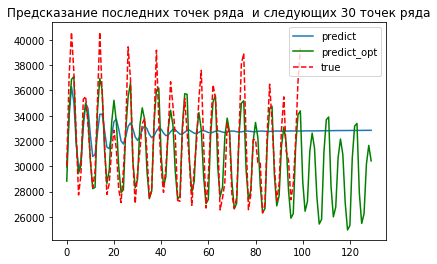

In [15]:
pred_dynamic_opt = results.forecast(len(data['PJME_MW'].values[:-100])+30)    #делаем предсказание на 10 точки от текущего конца ряда
pred_dynamic = result_s.forecast(len(data['PJME_MW'].values[:-100])+30)    #делаем предсказание на 10 точки от текущего конца ряда


plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data['PJME_MW'].values[-100:],'--r',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

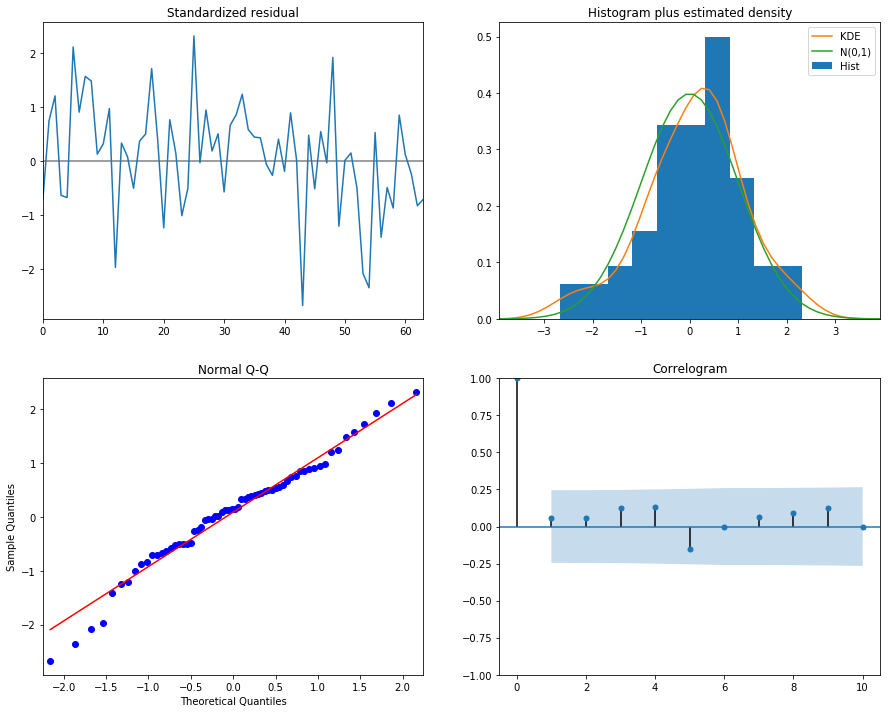

In [47]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


Оптимальная модель results показывает заметно лучший результат по сравнению с интуитивной. ЭТО УСПЕХ. Но остатки модели не совсем стационарны (хвост на Q-Q). Можно взять другие участки ряда и проверить параметры модели на них(применить кросс-проверку). Однако Коррелограма показывает. что остатки независимы, а по оценке распределения видно, что явление для остатков близко к нормальному закону.

Однако, модель в такой форме не единственная. ПОСТРОИМ МОДЕЛЬ БЕЗ СЕЗОНА.

Так можно, но модель основной части будет значительно сложней. Зададим диапазон изменения p ,q = [0,14] (период ряда 12 - сделаем запас по глубине истории и сглаживания до 14) и порядок интегрирования оставим низким

In [42]:
import itertools
# Определим p, d и q в диапазоне 0-3
p = range(0, 14)
d = range(0, 1)
q = range(0, 14)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
p = range(0, 0)
d = range(0, 0)
q = range(0, 0)
seasonal_pdq =[[0,0,0,0]] # нет сезона

aics = {}

for kk in range(len(pdq)):
    for k in range(len(seasonal_pdq)):
        param = pdq[kk]
        
        print(param)
        try:
            mod_b0 = sm.tsa.statespace.SARIMAX((data['PJME_MW'].values[:-100]),
                                              order=param,seasonal_order=[0,0,0,0],trend='ct',
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)

            results_0 = mod_b0.fit()
            aics[results_0.aic] = param
            print('ARIMA{}x{} - AIC:{}'.format(param, params, results_0.aic))
        except:
            continue

(0, 0, 0)
ARIMA(0, 0, 0)x[0, 0, 0, 0] - AIC:1893.6261539613051
(0, 0, 1)
ARIMA(0, 0, 1)x[0, 0, 0, 0] - AIC:1832.2941140245123
(0, 0, 2)
ARIMA(0, 0, 2)x[0, 0, 0, 0] - AIC:1790.2482610306029
(0, 0, 3)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 3)x[0, 0, 0, 0] - AIC:1761.6277079148226
(0, 0, 4)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 4)x[0, 0, 0, 0] - AIC:1739.3025443689305
(0, 0, 5)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 5)x[0, 0, 0, 0] - AIC:1714.8579154832782
(0, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 6)x[0, 0, 0, 0] - AIC:1701.039739776925
(0, 0, 7)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 7)x[0, 0, 0, 0] - AIC:1706.4206530780762
(0, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 8)x[0, 0, 0, 0] - AIC:1693.9972213679655
(0, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 9)x[0, 0, 0, 0] - AIC:1677.9411762496316
(0, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 10)x[0, 0, 0, 0] - AIC:1664.083160042572
(0, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 11)x[0, 0, 0, 0] - AIC:1639.2265760002974
(0, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 12)x[0, 0, 0, 0] - AIC:1617.4182077816515
(0, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 13)x[0, 0, 0, 0] - AIC:1602.6418441422895
(1, 0, 0)
ARIMA(1, 0, 0)x[0, 0, 0, 0] - AIC:1868.4785914974618
(1, 0, 1)
ARIMA(1, 0, 1)x[0, 0, 0, 0] - AIC:1825.5715251573363
(1, 0, 2)
ARIMA(1, 0, 2)x[0, 0, 0, 0] - AIC:1805.5700783736593
(1, 0, 3)
ARIMA(1, 0, 3)x[0, 0, 0, 0] - AIC:1771.1449047694236
(1, 0, 4)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 4)x[0, 0, 0, 0] - AIC:1755.0810545838044
(1, 0, 5)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 5)x[0, 0, 0, 0] - AIC:1738.5068153530985
(1, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 6)x[0, 0, 0, 0] - AIC:1715.4322576390045
(1, 0, 7)
ARIMA(1, 0, 7)x[0, 0, 0, 0] - AIC:1697.254754167753
(1, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 8)x[0, 0, 0, 0] - AIC:1682.728888673698
(1, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 9)x[0, 0, 0, 0] - AIC:1669.8857024166678
(1, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 10)x[0, 0, 0, 0] - AIC:1674.7087326162005
(1, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 11)x[0, 0, 0, 0] - AIC:1627.1490174872358
(1, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 12)x[0, 0, 0, 0] - AIC:1611.2461788739736
(1, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 13)x[0, 0, 0, 0] - AIC:1629.8360061329197
(2, 0, 0)
ARIMA(2, 0, 0)x[0, 0, 0, 0] - AIC:1775.5118778892604
(2, 0, 1)
ARIMA(2, 0, 1)x[0, 0, 0, 0] - AIC:1789.369722850221
(2, 0, 2)
ARIMA(2, 0, 2)x[0, 0, 0, 0] - AIC:1742.0398323224463
(2, 0, 3)
ARIMA(2, 0, 3)x[0, 0, 0, 0] - AIC:1723.7989918149053
(2, 0, 4)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 4)x[0, 0, 0, 0] - AIC:1704.5488951059122
(2, 0, 5)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 5)x[0, 0, 0, 0] - AIC:1682.92189812095
(2, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 6)x[0, 0, 0, 0] - AIC:1653.133621961718
(2, 0, 7)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 7)x[0, 0, 0, 0] - AIC:1639.4027799148564
(2, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 8)x[0, 0, 0, 0] - AIC:1622.910991976698
(2, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 9)x[0, 0, 0, 0] - AIC:1619.1894159139802
(2, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 10)x[0, 0, 0, 0] - AIC:1602.7042972169825
(2, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 11)x[0, 0, 0, 0] - AIC:1593.2221858488333
(2, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 12)x[0, 0, 0, 0] - AIC:1565.0718279643327
(2, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 13)x[0, 0, 0, 0] - AIC:1555.5309323767692
(3, 0, 0)
ARIMA(3, 0, 0)x[0, 0, 0, 0] - AIC:1752.3637427926835
(3, 0, 1)
ARIMA(3, 0, 1)x[0, 0, 0, 0] - AIC:1753.6291924901543
(3, 0, 2)
ARIMA(3, 0, 2)x[0, 0, 0, 0] - AIC:1743.0463073948927
(3, 0, 3)
ARIMA(3, 0, 3)x[0, 0, 0, 0] - AIC:1725.48014329533
(3, 0, 4)
ARIMA(3, 0, 4)x[0, 0, 0, 0] - AIC:1708.6426809509703
(3, 0, 5)
ARIMA(3, 0, 5)x[0, 0, 0, 0] - AIC:1685.1379574455402
(3, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 6)x[0, 0, 0, 0] - AIC:1650.989203794836
(3, 0, 7)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 7)x[0, 0, 0, 0] - AIC:1630.1716165971009
(3, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 8)x[0, 0, 0, 0] - AIC:1616.8956785347762
(3, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 9)x[0, 0, 0, 0] - AIC:1603.376340065514
(3, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 10)x[0, 0, 0, 0] - AIC:1587.9480634564186
(3, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 11)x[0, 0, 0, 0] - AIC:1566.2603426384376
(3, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 12)x[0, 0, 0, 0] - AIC:1551.3106595343488
(3, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 13)x[0, 0, 0, 0] - AIC:1540.1383902913942
(4, 0, 0)
ARIMA(4, 0, 0)x[0, 0, 0, 0] - AIC:1731.5876056369157
(4, 0, 1)
ARIMA(4, 0, 1)x[0, 0, 0, 0] - AIC:1732.9691162176882
(4, 0, 2)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 2)x[0, 0, 0, 0] - AIC:1722.7756038507491
(4, 0, 3)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 3)x[0, 0, 0, 0] - AIC:1726.2857946333834
(4, 0, 4)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 4)x[0, 0, 0, 0] - AIC:1710.3252813104198
(4, 0, 5)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 5)x[0, 0, 0, 0] - AIC:1683.1368808790667
(4, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 6)x[0, 0, 0, 0] - AIC:1668.8670839514673
(4, 0, 7)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 7)x[0, 0, 0, 0] - AIC:1635.1750863139755
(4, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 8)x[0, 0, 0, 0] - AIC:1619.5251362083193
(4, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 9)x[0, 0, 0, 0] - AIC:1607.2023814853135
(4, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 10)x[0, 0, 0, 0] - AIC:1589.8982141307897
(4, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 11)x[0, 0, 0, 0] - AIC:1567.6568596346601
(4, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 12)x[0, 0, 0, 0] - AIC:1553.18235823319
(4, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 13)x[0, 0, 0, 0] - AIC:1541.5450083683934
(5, 0, 0)
ARIMA(5, 0, 0)x[0, 0, 0, 0] - AIC:1711.8142387974988
(5, 0, 1)
ARIMA(5, 0, 1)x[0, 0, 0, 0] - AIC:1713.8140067991048
(5, 0, 2)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 2)x[0, 0, 0, 0] - AIC:1703.503680507482
(5, 0, 3)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 3)x[0, 0, 0, 0] - AIC:1710.6712676141333
(5, 0, 4)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 4)x[0, 0, 0, 0] - AIC:1712.272400200778
(5, 0, 5)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 5)x[0, 0, 0, 0] - AIC:1680.3144479151372
(5, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 6)x[0, 0, 0, 0] - AIC:1665.838177402004
(5, 0, 7)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 7)x[0, 0, 0, 0] - AIC:1635.0465193099067
(5, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 8)x[0, 0, 0, 0] - AIC:1625.5133045769105
(5, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 9)x[0, 0, 0, 0] - AIC:1612.974084662963
(5, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 10)x[0, 0, 0, 0] - AIC:1596.0107762476175
(5, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 11)x[0, 0, 0, 0] - AIC:1570.0308198527653
(5, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 12)x[0, 0, 0, 0] - AIC:1558.527464116509
(5, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 13)x[0, 0, 0, 0] - AIC:1540.3164881999978
(6, 0, 0)
ARIMA(6, 0, 0)x[0, 0, 0, 0] - AIC:1692.716623682083
(6, 0, 1)
ARIMA(6, 0, 1)x[0, 0, 0, 0] - AIC:1691.9764679867912
(6, 0, 2)
ARIMA(6, 0, 2)x[0, 0, 0, 0] - AIC:1689.5508449919678
(6, 0, 3)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 3)x[0, 0, 0, 0] - AIC:1683.9303250489577
(6, 0, 4)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 4)x[0, 0, 0, 0] - AIC:1683.5583827723751
(6, 0, 5)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 5)x[0, 0, 0, 0] - AIC:1684.284446922084
(6, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 6)x[0, 0, 0, 0] - AIC:1662.1946442088895
(6, 0, 7)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 7)x[0, 0, 0, 0] - AIC:1636.2819309225188
(6, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 8)x[0, 0, 0, 0] - AIC:1625.8041686262911
(6, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 9)x[0, 0, 0, 0] - AIC:1615.1571654970874
(6, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 10)x[0, 0, 0, 0] - AIC:1594.7540068077144
(6, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 11)x[0, 0, 0, 0] - AIC:1574.1559315750333
(6, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 12)x[0, 0, 0, 0] - AIC:1558.800481863941
(6, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 13)x[0, 0, 0, 0] - AIC:1544.314066593286
(7, 0, 0)
ARIMA(7, 0, 0)x[0, 0, 0, 0] - AIC:1668.8756224135088
(7, 0, 1)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 1)x[0, 0, 0, 0] - AIC:1668.4918300237969
(7, 0, 2)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 2)x[0, 0, 0, 0] - AIC:1665.183646047601
(7, 0, 3)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 3)x[0, 0, 0, 0] - AIC:1660.5867321812952
(7, 0, 4)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 4)x[0, 0, 0, 0] - AIC:1751.290895067975
(7, 0, 5)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 5)x[0, 0, 0, 0] - AIC:1683.3276283347366
(7, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 6)x[0, 0, 0, 0] - AIC:1664.0709422281645
(7, 0, 7)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 7)x[0, 0, 0, 0] - AIC:1637.05622441649
(7, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 8)x[0, 0, 0, 0] - AIC:1624.3692262585917
(7, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 9)x[0, 0, 0, 0] - AIC:1610.6161129639179
(7, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 10)x[0, 0, 0, 0] - AIC:1589.8514484511174
(7, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 11)x[0, 0, 0, 0] - AIC:1561.9134587921508
(7, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 12)x[0, 0, 0, 0] - AIC:1552.1036537610946
(7, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 13)x[0, 0, 0, 0] - AIC:1545.0072321872512
(8, 0, 0)
ARIMA(8, 0, 0)x[0, 0, 0, 0] - AIC:1647.0595676870453
(8, 0, 1)
ARIMA(8, 0, 1)x[0, 0, 0, 0] - AIC:1649.0586393629071
(8, 0, 2)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 2)x[0, 0, 0, 0] - AIC:1651.5708890103886
(8, 0, 3)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 3)x[0, 0, 0, 0] - AIC:1643.7605518055786
(8, 0, 4)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 4)x[0, 0, 0, 0] - AIC:2248.8948481801135
(8, 0, 5)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 5)x[0, 0, 0, 0] - AIC:1663.4049939129093
(8, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 6)x[0, 0, 0, 0] - AIC:1638.133029608323
(8, 0, 7)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 7)x[0, 0, 0, 0] - AIC:1634.2932485750482
(8, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 8)x[0, 0, 0, 0] - AIC:1622.8440540783774
(8, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 9)x[0, 0, 0, 0] - AIC:1605.4994518934311
(8, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 10)x[0, 0, 0, 0] - AIC:1584.967587551958
(8, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 11)x[0, 0, 0, 0] - AIC:1563.6918893583893
(8, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 12)x[0, 0, 0, 0] - AIC:1553.2160339491797
(8, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 13)x[0, 0, 0, 0] - AIC:1537.5778219701476
(9, 0, 0)
ARIMA(9, 0, 0)x[0, 0, 0, 0] - AIC:1628.7071471765962
(9, 0, 1)
ARIMA(9, 0, 1)x[0, 0, 0, 0] - AIC:1630.5097805871526
(9, 0, 2)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 2)x[0, 0, 0, 0] - AIC:1625.48433129402
(9, 0, 3)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 3)x[0, 0, 0, 0] - AIC:1621.8911429151733
(9, 0, 4)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 4)x[0, 0, 0, 0] - AIC:1699.11710049904
(9, 0, 5)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 5)x[0, 0, 0, 0] - AIC:1649.5351488775225
(9, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 6)x[0, 0, 0, 0] - AIC:1629.1037699065519
(9, 0, 7)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 7)x[0, 0, 0, 0] - AIC:1620.7902977184988
(9, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 8)x[0, 0, 0, 0] - AIC:1638.7038973027843
(9, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 9)x[0, 0, 0, 0] - AIC:1608.2401949486539
(9, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 10)x[0, 0, 0, 0] - AIC:1593.122082184829
(9, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 11)x[0, 0, 0, 0] - AIC:1564.9212378178609
(9, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 12)x[0, 0, 0, 0] - AIC:1553.222303308627
(9, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 13)x[0, 0, 0, 0] - AIC:1536.5521159020664
(10, 0, 0)
ARIMA(10, 0, 0)x[0, 0, 0, 0] - AIC:1611.9873138915693
(10, 0, 1)
ARIMA(10, 0, 1)x[0, 0, 0, 0] - AIC:1612.9404635358535
(10, 0, 2)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 2)x[0, 0, 0, 0] - AIC:1616.433811265452
(10, 0, 3)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 3)x[0, 0, 0, 0] - AIC:1605.5600524485014
(10, 0, 4)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 4)x[0, 0, 0, 0] - AIC:1617.4608115368426
(10, 0, 5)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 5)x[0, 0, 0, 0] - AIC:1620.6063734731429
(10, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 6)x[0, 0, 0, 0] - AIC:1619.1992540525732
(10, 0, 7)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 7)x[0, 0, 0, 0] - AIC:1606.5560283650173
(10, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 8)x[0, 0, 0, 0] - AIC:1616.7723258766123
(10, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 9)x[0, 0, 0, 0] - AIC:1618.6127718159048
(10, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 10)x[0, 0, 0, 0] - AIC:1606.8393286632684
(10, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 11)x[0, 0, 0, 0] - AIC:1579.5952049501307
(10, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 12)x[0, 0, 0, 0] - AIC:1553.6603007871747
(10, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 13)x[0, 0, 0, 0] - AIC:1538.166313695723
(11, 0, 0)
ARIMA(11, 0, 0)x[0, 0, 0, 0] - AIC:1580.8916501223064
(11, 0, 1)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 1)x[0, 0, 0, 0] - AIC:1581.6477068024506
(11, 0, 2)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 2)x[0, 0, 0, 0] - AIC:1581.0049270784634
(11, 0, 3)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 3)x[0, 0, 0, 0] - AIC:1582.9065158542558
(11, 0, 4)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 4)x[0, 0, 0, 0] - AIC:1600.0417149871623
(11, 0, 5)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 5)x[0, 0, 0, 0] - AIC:1592.5098150760728
(11, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 6)x[0, 0, 0, 0] - AIC:1628.3410249634414
(11, 0, 7)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 7)x[0, 0, 0, 0] - AIC:1584.4514866457232
(11, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 8)x[0, 0, 0, 0] - AIC:1589.9105116629323
(11, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 9)x[0, 0, 0, 0] - AIC:1591.3762489320197
(11, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 10)x[0, 0, 0, 0] - AIC:1596.092765855008
(11, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 11)x[0, 0, 0, 0] - AIC:1573.284881011181
(11, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 12)x[0, 0, 0, 0] - AIC:1577.4018080938388
(11, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 13)x[0, 0, 0, 0] - AIC:1536.2068516066197
(12, 0, 0)
ARIMA(12, 0, 0)x[0, 0, 0, 0] - AIC:1560.517558469981
(12, 0, 1)
ARIMA(12, 0, 1)x[0, 0, 0, 0] - AIC:1562.4816561875991
(12, 0, 2)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 2)x[0, 0, 0, 0] - AIC:1564.8396718924137
(12, 0, 3)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 3)x[0, 0, 0, 0] - AIC:1564.4975458811562
(12, 0, 4)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 4)x[0, 0, 0, 0] - AIC:1564.859538444513
(12, 0, 5)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 5)x[0, 0, 0, 0] - AIC:1561.860393341888
(12, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 6)x[0, 0, 0, 0] - AIC:1742.6224881144508
(12, 0, 7)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 7)x[0, 0, 0, 0] - AIC:1588.6527150361153
(12, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 8)x[0, 0, 0, 0] - AIC:1564.5750201687451
(12, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 9)x[0, 0, 0, 0] - AIC:1563.6241876226181
(12, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 10)x[0, 0, 0, 0] - AIC:1576.5428066105
(12, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 11)x[0, 0, 0, 0] - AIC:1567.3878483499673
(12, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 12)x[0, 0, 0, 0] - AIC:1582.5234883486057
(12, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 13)x[0, 0, 0, 0] - AIC:1548.3636876296052
(13, 0, 0)
ARIMA(13, 0, 0)x[0, 0, 0, 0] - AIC:1543.6259468435576
(13, 0, 1)
ARIMA(13, 0, 1)x[0, 0, 0, 0] - AIC:1545.2289606620436
(13, 0, 2)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 2)x[0, 0, 0, 0] - AIC:1546.9496749423693
(13, 0, 3)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 3)x[0, 0, 0, 0] - AIC:1548.2930574232714
(13, 0, 4)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 4)x[0, 0, 0, 0] - AIC:1548.5683997045526
(13, 0, 5)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 5)x[0, 0, 0, 0] - AIC:1544.1589552214743
(13, 0, 6)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 6)x[0, 0, 0, 0] - AIC:1682.5245630369648
(13, 0, 7)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 7)x[0, 0, 0, 0] - AIC:1556.0828183132223
(13, 0, 8)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 8)x[0, 0, 0, 0] - AIC:1552.5465396161483
(13, 0, 9)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 9)x[0, 0, 0, 0] - AIC:1550.2806580676634
(13, 0, 10)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 10)x[0, 0, 0, 0] - AIC:1559.372518515697
(13, 0, 11)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 11)x[0, 0, 0, 0] - AIC:1548.9793230502567
(13, 0, 12)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 12)x[0, 0, 0, 0] - AIC:1566.3851249558247
(13, 0, 13)


C:\Users\1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 13)x[0, 0, 0, 0] - AIC:1544.5315193677052


Посмотрим на качество моделей

In [43]:
aics


{1893.6261539613051: (0, 0, 0),
 1832.2941140245123: (0, 0, 1),
 1790.2482610306029: (0, 0, 2),
 1761.6277079148226: (0, 0, 3),
 1739.3025443689305: (0, 0, 4),
 1714.8579154832782: (0, 0, 5),
 1701.039739776925: (0, 0, 6),
 1706.4206530780762: (0, 0, 7),
 1693.9972213679655: (0, 0, 8),
 1677.9411762496316: (0, 0, 9),
 1664.083160042572: (0, 0, 10),
 1639.2265760002974: (0, 0, 11),
 1617.4182077816515: (0, 0, 12),
 1602.6418441422895: (0, 0, 13),
 1868.4785914974618: (1, 0, 0),
 1825.5715251573363: (1, 0, 1),
 1805.5700783736593: (1, 0, 2),
 1771.1449047694236: (1, 0, 3),
 1755.0810545838044: (1, 0, 4),
 1738.5068153530985: (1, 0, 5),
 1715.4322576390045: (1, 0, 6),
 1697.254754167753: (1, 0, 7),
 1682.728888673698: (1, 0, 8),
 1669.8857024166678: (1, 0, 9),
 1674.7087326162005: (1, 0, 10),
 1627.1490174872358: (1, 0, 11),
 1611.2461788739736: (1, 0, 12),
 1629.8360061329197: (1, 0, 13),
 1775.5118778892604: (2, 0, 0),
 1789.369722850221: (2, 0, 1),
 1742.0398323224463: (2, 0, 2),
 1723

Выбираем модель (12,0,0) - самая простая из хороших (около 1500 по AIC) - вот опять сезонность с лагом 12.

In [44]:
result_2 = sm.tsa.statespace.SARIMAX((data['PJME_MW'].values[-500:-100]),
                                          order=[12,0, 0],seasonal_order=[0,0,0,0],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
result_s_0 = result_2.fit()    

Нарисуем : модель похожа на модель с сезонностью (несколько хуже, т.к. она проще ). Цикли проявлены, для предсказания имеем неплохой результат, но остатки этой модели не идеальны (хвосты на Q-Q).

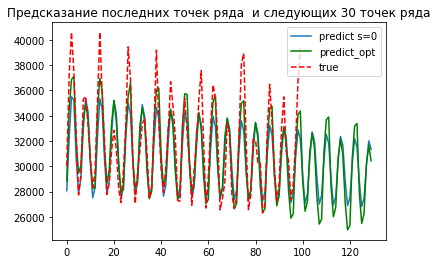

In [45]:
pred_dynamic_opt = results.forecast(len(data['PJME_MW'].values[:-100])+30)    #делаем предсказание на 10 точки от текущего конца ряда
pred_dynamic_s0 = result_s_0.forecast(len(data['PJME_MW'].values[:-100])+30)    #делаем предсказание на 10 точки от текущего конца ряда


plt.plot(pred_dynamic_s0, label='predict s=0' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data['PJME_MW'].values[-100:],'--r',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

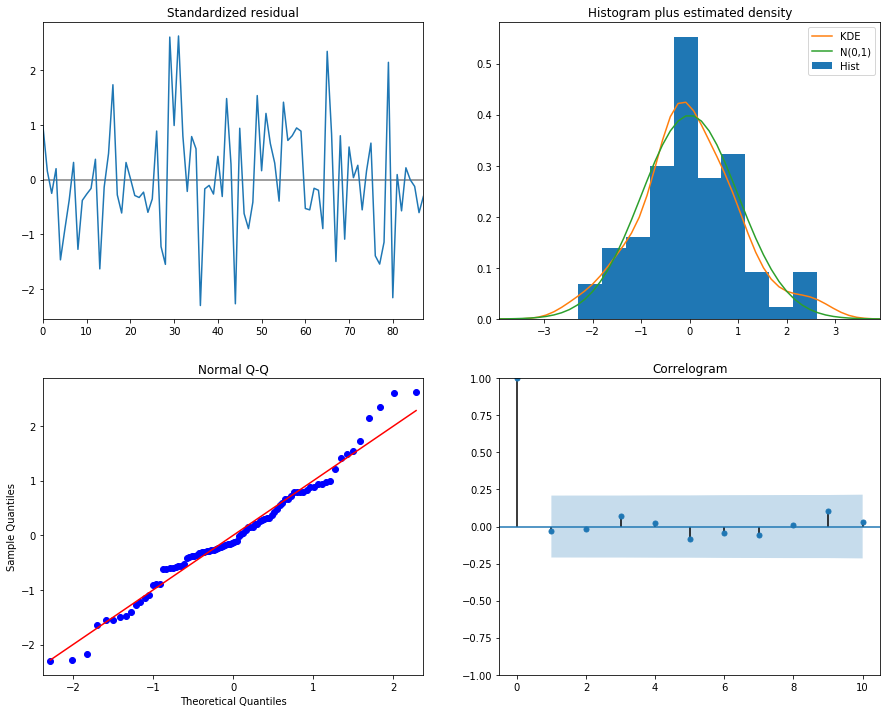

In [46]:
result_s_0.plot_diagnostics(figsize=(15, 12))
plt.show()
